In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tqdm import tqdm

In [17]:
nltk.download('stopwords')
nltk.download('punkt')
BASE_PATH = "D:\\University\\7 Fall 2023\\CMSC516\\Project 1\\Datasets\\"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\majd2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\majd2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
# Professor's dataset
train_df01 = pd.read_csv(BASE_PATH + "sentiment-train.tsv", delimiter='\t', encoding = "ISO-8859-1", header=None, names=['label', 'tweet'])
test_df01 = pd.read_csv(BASE_PATH + "sentiment-test.tsv", delimiter='\t', encoding = "ISO-8859-1", header=None, names=['label', 'tweet'])

# Sentiment140 dataset
train_df02 = pd.read_csv(BASE_PATH + "training1.6.csv", header=None, encoding = "ISO-8859-1")
test_df02 = pd.read_csv(BASE_PATH + "testdata1.6.csv", header=None, encoding = "ISO-8859-1")

# Airlines Sentiment dataset
train_df03 = pd.read_csv(BASE_PATH + "Tweets.csv", encoding = "ISO-8859-1", header=None, names=['label', 'tweet'])
train_df03 = train_df03[1:]

# Kaggel Dataset https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset
train_df04 = pd.read_csv(BASE_PATH + "Twitter_Data.csv", encoding = "ISO-8859-1", header=None, names=['label', 'tweet'])
train_df04.dropna(inplace=True)
train_df04.reset_index(drop=True, inplace=True)

# Merged Airlines Sentiment
temp_df01 = pd.concat([train_df01, test_df01, train_df03] ,axis = 0, ignore_index=True)
temp_df01.dropna(inplace=True)
temp_df01.reset_index(drop=True, inplace=True)

# Merged Professor's and Sentiment140 dataset
temp_df02 = pd.concat([train_df02, test_df02] ,axis = 0, ignore_index=True)
temp_df02.dropna(inplace=True)
temp_df02.reset_index(drop=True, inplace=True)

Sentiment140_df = pd.concat([temp_df02.loc[:, 0], temp_df02.loc[:, 5]] ,axis = 1, keys=['label', 'tweet'])
Sentiment140_df.dropna(inplace=True)
Sentiment140_df.reset_index(drop=True, inplace=True)


In [20]:
# Unifying the labbel encoding through out the datasets

Sentiment140_df['label'].replace([0], 'negative', inplace=True)
Sentiment140_df['label'].replace([2], 'neutral', inplace=True)
Sentiment140_df['label'].replace([4], 'positive', inplace=True)

train_df04['label'].replace([-1.0], 'negative',  inplace=True)
train_df04['label'].replace([0.0], 'neutral',  inplace=True)
train_df04['label'].replace([1.0], 'positive',  inplace=True)

# Meging all the datasets together
full_dataset = pd.concat([Sentiment140_df, temp_df01, train_df04], axis=0, ignore_index = True)
full_dataset.drop_duplicates(inplace=True)
full_dataset.dropna(inplace=True)

In [24]:
# column 0 has the sentiment of the tweet 
# it is encoded (0 = negative, 2 = neutral, 4 = positive)
# the required columns are only of index 0 and 5


negative_label_count = len(full_dataset[full_dataset['label'] == 'negative'])
neutral_label_count = len(full_dataset[full_dataset['label'] == 'neutral'])
positive_label_count = len(full_dataset[full_dataset['label'] == 'positive'])


print("Size of the dataset: {}".format(len(full_dataset)))
print("Size of the negative class: {}".format(negative_label_count))
print("Size of the neutral class: {}".format(neutral_label_count))
print("Size of the positive class: {}".format(positive_label_count))

Size of the dataset: 1762068
Size of the negative class: 835102
Size of the neutral class: 58416
Size of the positive class: 868550


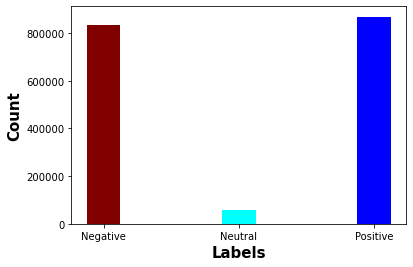

In [25]:
# set width of bar
barWidth = 0.25
# fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
count = [negative_label_count, neutral_label_count, positive_label_count]
label = ["Negative", "Neutral",  "Positive"]

plt.bar(label[0], count[0], color ='maroon', width = barWidth)
plt.bar(label[1], count[1], color ='cyan', width = barWidth)
plt.bar(label[2], count[2], color ='blue', width = barWidth)
 
plt.xlabel('Labels', fontweight ='bold', fontsize = 15)
plt.ylabel('Count', fontweight ='bold', fontsize = 15)

plt.show()

In [27]:
# Droping the Netural class for its significantly smaller size
# drop all the rows where label == 'neutral'

full_dataset = full_dataset[full_dataset.label != 'neutral']
full_dataset.reset_index(drop=True, inplace=True)

negative_label_count = len(full_dataset[full_dataset['label'] == 'negative'])
neutral_label_count = len(full_dataset[full_dataset['label'] == 'neutral'])
positive_label_count = len(full_dataset[full_dataset['label'] == 'positive'])


print("Size of the dataset: {}".format(len(full_dataset)))
print("Size of the negative class: {}".format(negative_label_count))
print("Size of the neutral class: {}".format(neutral_label_count))
print("Size of the positive class: {}".format(positive_label_count))

Size of the dataset: 1703652
Size of the negative class: 835102
Size of the neutral class: 0
Size of the positive class: 868550


In [36]:
all_stopwords = stopwords.words('english')
stemmer = PorterStemmer()


def pre_process(data, stemmer, stopwords):
    i = 0
    final_data = []
    for i in tqdm(range(len(data))):
        datum = data[i]
        # Remove all the special characters
        datum = re.sub(r'[^a-zA-Z0-9]', ' ', str(datum))
        # remove all single characters
        datum = re.sub(r'\s+[a-zA-Z]\s+', ' ', datum)
        # Remove single characters from the start
        datum = re.sub(r'\^[a-zA-Z]\s+', ' ', datum)
        # Substituting multiple spaces with single space
        datum = re.sub(r'\s+', ' ', datum, flags=re.I)
        # Removing prefixed 'b'
        datum = re.sub(r'^b\s+', '', datum)
        # Converting to Lowercase
        datum = datum.lower()

        tokens = word_tokenize(datum)
        # has the words of a tweet after removing stop words and stemming
        tokens_processed = [stemmer.stem(
            word) for word in tokens if not word in stopwords]

        sentence = ' '.join(tokens_processed)
        final_data.append(sentence)
    return final_data

def get_irregular_rows(dataset):
    irregular_rows = []
    for i in tqdm(range(len(dataset))):
        row = dataset.loc[i]
        if dataset.loc[1]['label'] != 'negative' or dataset.loc[1]['label'] != 'negative':
            irregular_rows.append(i)
    return irregular_rows

In [ ]:
y = full_dataset.iloc[:,0]
X = full_dataset.iloc[:,1]

In [37]:
X_pre_processed = pre_process(X, stemmer, all_stopwords)

100%|██████████| 1703652/1703652 [08:02<00:00, 3528.57it/s]


In [61]:
dataset = pd.concat([y, pd.Series(X_pre_processed)], axis = 1, keys=['label', 'tweet'])
irregular_rows = get_irregular_rows(dataset)

if len(irregular_rows) < 1:
    dataset.to_csv(BASE_PATH + "preprocessed_dataset.csv")
    print("dataset is ready for use\nName of the data final_dataset.csv")
else:
    print("There are issues with the dataset, it requires further inspection")

100%|██████████| 1703652/1703652 [04:43<00:00, 6018.42it/s]


dataset is ready for use
Name of the data final_dataset.csv
